<a href="https://colab.research.google.com/github/yangchangwoo/head_modeling/blob/master/head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- commit test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
# 폴더가 존재하지 않으면 경로에 압축해제
if not os.path.exists('vv'):
  path = '/content/drive/MyDrive/output_images.zip'
  f_zip = zipfile.ZipFile(path)
  f_zip.extractall('./vv')
  f_zip.close()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# 이미지 폴더 및 CSV 파일 경로
image_folder = '/content/vv'
csv_file_path = '/content/drive/MyDrive/keypoints.csv'

# CSV 파일 로드
data = pd.read_csv(csv_file_path)

# 이미지와 좌표 저장 리스트
images = []
coordinates = []

for idx, row in data.iterrows():
    image_file = row['Image Name']
    image_path = os.path.join(image_folder, image_file)

    # 이미지 로드
    image = cv2.imread(image_path)

    # 이미지가 None일 경우 파일 로드 실패
    if image is None:
        print(f"Failed to load image: {image_file}")
        continue

    # 이미지를 224x224로 리사이즈
    image_resized = cv2.resize(image, (224, 224))

    # 정규화
    image_normalized = image_resized / 255.0
    images.append(image_normalized)

    # 좌표 데이터 추출 및 저장
    coords = [
        row['Red X'], row['Red Y'],
        row['Green X'], row['Green Y'],
        row['Blue X'], row['Blue Y']
    ]
    coordinates.append(coords)

# 이미지와 좌표 배열로 변환
images = np.array(images)
coordinates = np.array(coordinates)

# 데이터 확인
print(f"Loaded {len(images)} images and coordinates.")


Loaded 432 images and coordinates.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터셋 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(images, coordinates, test_size=0.2, random_state=42)

# ResNet50 모델 불러오기 (사전 학습된 모델 사용)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 출력층을 좌표 예측에 맞게 수정
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(6)(x)  # 6개의 좌표 (Red X, Red Y, Green X, Green Y, Blue X, Blue Y)

# 새 모델 정의
model = Model(inputs=base_model.input, outputs=output)

# ResNet50의 모든 기본층을 고정하여 학습 불가능하게 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일 (손실 함수: MSE)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# 모델 구조 출력
model.summary()





94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 126,877,062 (484.00 MB)

 Trainable params: 103,289,350 (394.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mse'])

# 조기 종료 콜백 (학습이 일정 횟수 동안 개선되지 않으면 종료)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습 (훈련 데이터를 사용해 학습시키기)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 105s 9s/step - loss: 17961.0195 - mse: 17961.0195 - val_loss: 7576.0977 - val_mse: 7576.0977
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 145s 9s/step - loss: 5496.6499 - mse: 5496.6499 - val_loss: 468.5823 - val_mse: 468.5823
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - loss: 840.2469 - mse: 840.2469 - val_loss: 874.1767 - val_mse: 874.1767
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - loss: 860.1827 - mse: 860.1827 - val_loss: 375.9828 - val_mse: 375.9828
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - loss: 526.1796 - mse: 526.1796 - val_loss: 348.2055 - val_mse: 348.2055
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - loss: 428.7845 - mse: 428.7845 - val_loss: 314.5453 - val_mse: 314.5453
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 460.1070 - mse: 460.1070 - val_loss: 304.9167 - val_mse: 304.9167
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - loss: 365.2716 - mse: 365.2716 - val_loss: 306.1462 - val_

In [ ]:
# @title 나중에 실행

import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터셋 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(images, coordinates, test_size=0.2, random_state=42)

# ResNet101 모델 불러오기 (사전 학습된 모델 사용)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 출력층을 좌표 예측에 맞게 수정
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(6)(x)  # 6개의 좌표 (Red X, Red Y, Green X, Green Y, Blue X, Blue Y)

# 새 모델 정의
model = Model(inputs=base_model.input, outputs=output)

# ResNet101의 모든 기본층을 고정하여 학습 불가능하게 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일 (손실 함수: MSE)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping: 검증 손실이 5 에포크 동안 개선되지 않으면 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau: 검증 손실이 3 에포크 동안 개선되지 않으면 학습률 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습 (에포크 100, 콜백 함수 추가)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)



In [ ]:
# 모델 평가 (테스트 데이터를 사용하여 성능 평가)
test_loss, test_mse = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 158.5549 - mse: 158.5549
Test Loss: 181.59072875976562
Test MSE: 181.59071350097656


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted coordinates: [[158.56122  225.0881   133.41606   28.605396 173.27538  101.68785 ]]


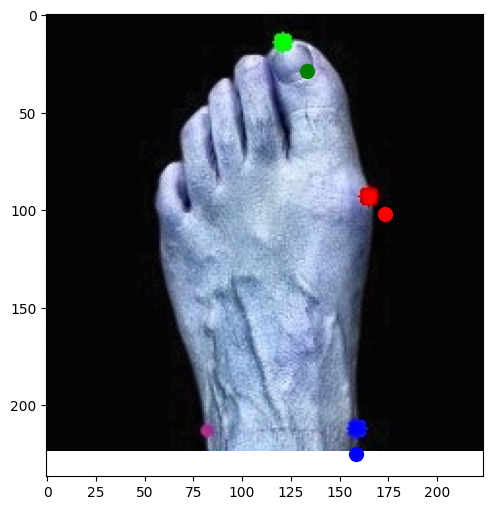

In [ ]:
import matplotlib.pyplot as plt

# 새로운 이미지에 대해 좌표 예측
predicted_coords = model.predict(X_test[:1])  # 테스트 데이터 중 첫 번째 이미지에 대한 좌표 예측
print(f"Predicted coordinates: {predicted_coords}")

# 예측된 좌표 (빨강, 초록, 파랑 점의 x, y 좌표)
predicted_red_x, predicted_red_y = predicted_coords[0][0], predicted_coords[0][1]
predicted_green_x, predicted_green_y = predicted_coords[0][2], predicted_coords[0][3]
predicted_blue_x, predicted_blue_y = predicted_coords[0][4], predicted_coords[0][5]

# 테스트 데이터의 첫 번째 이미지
image = X_test[1]

# 이미지 시각화 (Matplotlib 사용)
plt.figure(figsize=(6, 6))  # 이미지 크기 설정
plt.imshow(image)  # 이미지를 표시

# 예측된 좌표를 이미지에 점으로 표시
plt.scatter([predicted_red_x], [predicted_red_y], color='blue', label='Red Point', s=100)  # 빨강 점
plt.scatter([predicted_green_x], [predicted_green_y], color='green', label='Green Point', s=100)  # 초록 점
plt.scatter([predicted_blue_x], [predicted_blue_y], color='red', label='Blue Point', s=100)  # 파랑 점

# 범례와 출력

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
Predicted coordinates: [[166.70172  227.52312  139.87178   18.289297 180.11792  100.93688 ]]


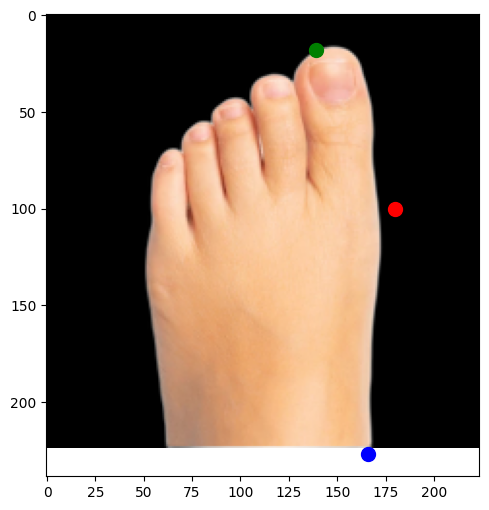

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 이미지 경로 설정 (기존 경로의 이미지 불러오기)
image_path = '/content/drive/MyDrive/sam.png'  # 사용자의 PNG 이미지 경로
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # PNG 파일을 알파 채널 포함하여 불러오기 (4채널일 수 있음)

# 만약 이미지가 4채널(RGBA)일 경우, 3채널(RGB)로 변환
if image.shape[2] == 4:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # 4채널(BGRA)을 3채널(BGR)로 변환
else:
    image_rgb = image  # 이미 3채널(BGR)인 경우 그대로 사용

# 이미지를 RGB로 변환 (Matplotlib에 맞게)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# 이미지를 모델 입력 크기인 (224, 224)로 리사이즈
input_image = cv2.resize(image_rgb, (224, 224))  # 모델에 맞게 크기 조정
input_image = input_image / 255.0  # 정규화
input_image = np.expand_dims(input_image, axis=0)  # 모델 입력 차원에 맞추기 위해 배치 차원 추가

# 모델을 사용하여 좌표 예측
predicted_coords = model.predict(input_image)
print(f"Predicted coordinates: {predicted_coords}")

# 예측된 좌표 (빨강, 초록, 파랑 점의 x, y 좌표)
predicted_red_x, predicted_red_y = predicted_coords[0][0], predicted_coords[0][1]
predicted_green_x, predicted_green_y = predicted_coords[0][2], predicted_coords[0][3]
predicted_blue_x, predicted_blue_y = predicted_coords[0][4], predicted_coords[0][5]

# 원본 이미지 크기에 맞게 좌표 복원 (비율에 따라 좌표 조정)
height, width, _ = image.shape
predicted_red_x = int(predicted_red_x * width / 224)
predicted_red_y = int(predicted_red_y * height / 224)
predicted_green_x = int(predicted_green_x * width / 224)
predicted_green_y = int(predicted_green_y * height / 224)
predicted_blue_x = int(predicted_blue_x * width / 224)
predicted_blue_y = int(predicted_blue_y * height / 224)

# 원본 이미지에 예측된 좌표 표시
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)  # 이미지를 RGB 형식으로 표시

# 예측된 좌표를 이미지에 점으로 표시
plt.scatter([predicted_red_x], [predicted_red_y], color='blue', label='Red Point', s=100)  # 빨강 점
plt.scatter([predicted_green_x], [predicted_green_y], color='green', label='Green Point', s=100)  # 초록 점
plt.scatter([predicted_blue_x], [predicted_blue_y], color='red', label='Blue Point', s=100)  # 파랑 점

# 범례와 출력
plt.show()


In [ ]:
model.save('current_model_weights.h5')  # 현재 모델 가중치 저장


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 학습률 스케줄링 콜백
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습에 학습률 스케줄링 추가
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 10s/step - loss: 235.3931 - mse: 235.3931 - val_loss: 190.7025 - val_mse: 190.7025 - learning_rate: 1.0000e-04
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 10s/step - loss: 311.5941 - mse: 311.5941 - val_loss: 183.2845 - val_mse: 183.2845 - learning_rate: 1.0000e-04
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - loss: 268.5814 - mse: 268.5814 - val_loss: 188.6754 - val_mse: 188.6754 - learning_rate: 1.0000e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 144s 10s/step - loss: 375.5525 - mse: 375.5525 - val_loss: 183.9529 - val_mse: 183.9529 - learning_rate: 1.0000e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 10s/step - loss: 259.2588 - mse: 259.2588 - val_loss: 183.2296 - val_mse: 183.2296 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted coordinates: [[160.88828  221.81677  135.5531    29.827814 173.57289  100.123055]]


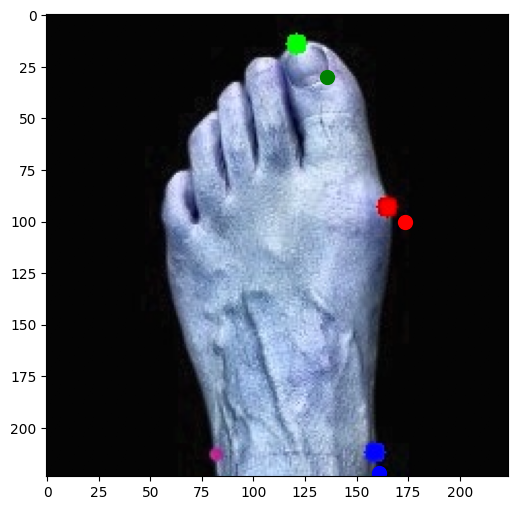

In [ ]:
import matplotlib.pyplot as plt

# 새로운 이미지에 대해 좌표 예측
predicted_coords = model.predict(X_test[:1])  # 테스트 데이터 중 첫 번째 이미지에 대한 좌표 예측
print(f"Predicted coordinates: {predicted_coords}")

# 예측된 좌표 (빨강, 초록, 파랑 점의 x, y 좌표)
predicted_red_x, predicted_red_y = predicted_coords[0][0], predicted_coords[0][1]
predicted_green_x, predicted_green_y = predicted_coords[0][2], predicted_coords[0][3]
predicted_blue_x, predicted_blue_y = predicted_coords[0][4], predicted_coords[0][5]

# 테스트 데이터의 첫 번째 이미지
image = X_test[1]

# 이미지 시각화 (Matplotlib 사용)
plt.figure(figsize=(6, 6))  # 이미지 크기 설정
plt.imshow(image)  # 이미지를 표시

# 예측된 좌표를 이미지에 점으로 표시
plt.scatter([predicted_red_x], [predicted_red_y], color='blue', label='Red Point', s=100)  # 빨강 점
plt.scatter([predicted_green_x], [predicted_green_y], color='green', label='Green Point', s=100)  # 초록 점
plt.scatter([predicted_blue_x], [predicted_blue_y], color='red', label='Blue Point', s=100)  # 파랑 점

# 범례와 출력

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Predicted coordinates: [[164.1384   221.34814  136.9383    22.223797 177.55972  100.67577 ]]


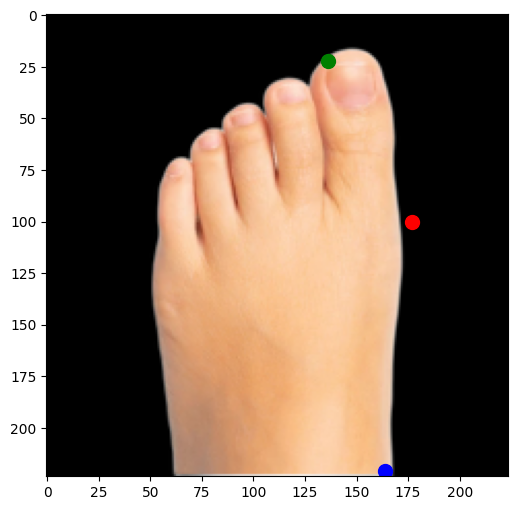

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 이미지 경로 설정 (기존 경로의 이미지 불러오기)
image_path = '/content/drive/MyDrive/sam.png'  # 사용자의 PNG 이미지 경로
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # PNG 파일을 알파 채널 포함하여 불러오기 (4채널일 수 있음)

# 만약 이미지가 4채널(RGBA)일 경우, 3채널(RGB)로 변환
if image.shape[2] == 4:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # 4채널(BGRA)을 3채널(BGR)로 변환
else:
    image_rgb = image  # 이미 3채널(BGR)인 경우 그대로 사용

# 이미지를 RGB로 변환 (Matplotlib에 맞게)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# 이미지를 모델 입력 크기인 (224, 224)로 리사이즈
input_image = cv2.resize(image_rgb, (224, 224))  # 모델에 맞게 크기 조정
input_image = input_image / 255.0  # 정규화
input_image = np.expand_dims(input_image, axis=0)  # 모델 입력 차원에 맞추기 위해 배치 차원 추가

# 모델을 사용하여 좌표 예측
predicted_coords = model.predict(input_image)
print(f"Predicted coordinates: {predicted_coords}")

# 예측된 좌표 (빨강, 초록, 파랑 점의 x, y 좌표)
predicted_red_x, predicted_red_y = predicted_coords[0][0], predicted_coords[0][1]
predicted_green_x, predicted_green_y = predicted_coords[0][2], predicted_coords[0][3]
predicted_blue_x, predicted_blue_y = predicted_coords[0][4], predicted_coords[0][5]

# 원본 이미지 크기에 맞게 좌표 복원 (비율에 따라 좌표 조정)
height, width, _ = image.shape
predicted_red_x = int(predicted_red_x * width / 224)
predicted_red_y = int(predicted_red_y * height / 224)
predicted_green_x = int(predicted_green_x * width / 224)
predicted_green_y = int(predicted_green_y * height / 224)
predicted_blue_x = int(predicted_blue_x * width / 224)
predicted_blue_y = int(predicted_blue_y * height / 224)

# 원본 이미지에 예측된 좌표 표시
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)  # 이미지를 RGB 형식으로 표시

# 예측된 좌표를 이미지에 점으로 표시
plt.scatter([predicted_red_x], [predicted_red_y], color='blue', label='Red Point', s=100)  # 빨강 점
plt.scatter([predicted_green_x], [predicted_green_y], color='green', label='Green Point', s=100)  # 초록 점
plt.scatter([predicted_blue_x], [predicted_blue_y], color='red', label='Blue Point', s=100)  # 파랑 점

# 범례와 출력
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# 데이터셋 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(images, coordinates, test_size=0.2, random_state=42)

# ResNet101 모델 불러오기 (사전 학습된 모델 사용)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 출력층을 좌표 예측에 맞게 수정
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(6)(x)  # 6개의 좌표 (Red X, Red Y, Green X, Green Y, Blue X, Blue Y)

# 새 모델 정의
model = Model(inputs=base_model.input, outputs=output)

# ResNet101의 모든 기본층을 고정하여 학습 불가능하게 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일 (손실 함수: MSE, 추가적으로 mse 메트릭 모니터링)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mse'])

# 조기 종료 콜백 설정 (patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 학습률 감소 콜백 설정 (patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 모델 학습 (에포크 100, 콜백 함수 추가)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


NameError: name 'images' is not defined

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mse'])

# 조기 종료 콜백 (학습이 일정 횟수 동안 개선되지 않으면 종료)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습 (훈련 데이터를 사용해 학습시키기)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 9s/step - loss: 343.2331 - mse: 343.2331 - val_loss: 195.0739 - val_mse: 195.0738
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 9s/step - loss: 277.1741 - mse: 277.1741 - val_loss: 200.2744 - val_mse: 200.2744
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - loss: 334.7103 - mse: 334.7103 - val_loss: 196.2399 - val_mse: 196.2399
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 298.9136 - mse: 298.9136 - val_loss: 220.0253 - val_mse: 220.0253
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 272.1931 - mse: 272.1931 - val_loss: 186.2812 - val_mse: 186.2812
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 335.7744 - mse: 335.7744 - val_loss: 185.8760 - val_mse: 185.8760
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - loss: 335.1967 - mse: 335.1967 - val_loss: 185.6787 - val_mse: 185.6787
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 276.3986 - mse: 276.3986 - val_loss: 205.0139 - val_mse: 205

In [ ]:
# 모델 평가 (테스트 데이터를 사용하여 성능 평가)
test_loss, test_mse = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 152.8723 - mse: 152.8723
Test Loss: 174.3769989013672
Test MSE: 174.3769989013672


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Predicted coordinates: [[169.7729   226.75514  139.91      26.282763 181.13307  104.13024 ]]


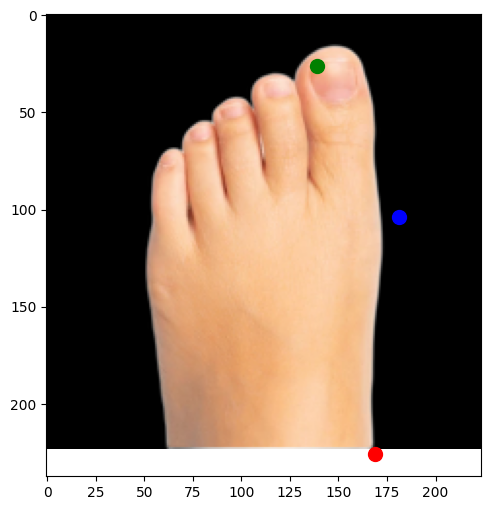

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 이미지 경로 설정 (기존 경로의 이미지 불러오기)
image_path = '/content/drive/MyDrive/sam.png'  # 사용자의 PNG 이미지 경로
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # PNG 파일을 알파 채널 포함하여 불러오기 (4채널일 수 있음)

# 만약 이미지가 4채널(RGBA)일 경우, 3채널(RGB)로 변환
if image.shape[2] == 4:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # 4채널(BGRA)을 3채널(BGR)로 변환
else:
    image_rgb = image  # 이미 3채널(BGR)인 경우 그대로 사용

# 이미지를 RGB로 변환 (Matplotlib에 맞게)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# 이미지를 모델 입력 크기인 (224, 224)로 리사이즈
input_image = cv2.resize(image_rgb, (224, 224))  # 모델에 맞게 크기 조정
input_image = input_image / 255.0  # 정규화
input_image = np.expand_dims(input_image, axis=0)  # 모델 입력 차원에 맞추기 위해 배치 차원 추가

# 모델을 사용하여 좌표 예측
predicted_coords = model.predict(input_image)
print(f"Predicted coordinates: {predicted_coords}")

# 예측된 좌표 (빨강, 초록, 파랑 점의 x, y 좌표)
predicted_red_x, predicted_red_y = predicted_coords[0][0], predicted_coords[0][1]
predicted_green_x, predicted_green_y = predicted_coords[0][2], predicted_coords[0][3]
predicted_blue_x, predicted_blue_y = predicted_coords[0][4], predicted_coords[0][5]

# 원본 이미지 크기에 맞게 좌표 복원 (비율에 따라 좌표 조정)
height, width, _ = image.shape
predicted_red_x = int(predicted_red_x * width / 224)
predicted_red_y = int(predicted_red_y * height / 224)
predicted_green_x = int(predicted_green_x * width / 224)
predicted_green_y = int(predicted_green_y * height / 224)
predicted_blue_x = int(predicted_blue_x * width / 224)
predicted_blue_y = int(predicted_blue_y * height / 224)

# 원본 이미지에 예측된 좌표 표시
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)  # 이미지를 RGB 형식으로 표시

# 예측된 좌표를 이미지에 점으로 표시
plt.scatter([predicted_red_x], [predicted_red_y], color='red', label='Red Point', s=100)  # 빨강 점
plt.scatter([predicted_green_x], [predicted_green_y], color='green', label='Green Point', s=100)  # 초록 점
plt.scatter([predicted_blue_x], [predicted_blue_y], color='blue', label='Blue Point', s=100)  # 파랑 점

# 범례와 출력
plt.show()


In [ ]:
model.save('current_model_weights.h5')  # 현재 모델 가중치 저장


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 기존 학습된 가중치 로드
model.load_weights('/content/current_model_weights.h5')

# 모델 컴파일 (손실 함수: MSE)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mse'])

# 조기 종료 콜백 (학습이 일정 횟수 동안 개선되지 않으면 종료)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습률 스케줄링 콜백 (학습률 감소)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 기존 모델의 학습을 이어서 수행
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # 추가적으로 50 에포크 학습
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 108s 9s/step - loss: 231.4220 - mse: 231.4220 - val_loss: 219.5116 - val_mse: 219.5116 - learning_rate: 1.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - loss: 309.3676 - mse: 309.3676 - val_loss: 179.7346 - val_mse: 179.7346 - learning_rate: 1.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - loss: 254.2461 - mse: 254.2461 - val_loss: 194.1824 - val_mse: 194.1824 - learning_rate: 1.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 9s/step - loss: 290.5941 - mse: 290.5941 - val_loss: 176.6348 - val_mse: 176.6348 - learning_rate: 1.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 257.9528 - mse: 257.9528 - val_loss: 178.8779 - val_mse: 178.8779 - learning_rate: 1.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 147s 9s/step - loss: 272.9670 - mse: 272.9670 - val_loss: 183.2037 - val_mse: 183.2037 - learning_rate: 1.0000e-04
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 9s/step - loss: 225.3997 - mse: 225.3997 